In [29]:
import math
import numpy as np
from matplotlib import pyplot as plt

In [30]:
# default arguments
num_walls = 8
diameter = 36.21
radius = diameter/2
angle_sep = 2*math.pi/num_walls  # angle between walls
vertex_offset = angle_sep/2      # angular distance between centre-wall and vertex 

# alcoves
alcove_length_scaled = 3.0       # depth of alcove in Blender/Unity units after scaling 
                                 # of Octagon in Unity
alcove_length_axis_projection = (alcove_length_scaled*math.sin(math.pi/4))/math.sin(math.pi/2) # Sin rule to find x and y coordinate
                                                                                               # offset from values in vertex_x/y
                                                                                               # This is the projection of the diagonal
                                                                                               # alcove walls onto the x and y axis

In [31]:
## Functions ##

In [32]:
# coordinate generation # 

In [33]:
# this will return lists of x and y coordinates, for vertices if vertex=True, and for
# wall centres if vertex=False
def calculate_coordinates(vertex=True, angle_sep=angle_sep, vertex_offset=vertex_offset, num_walls=num_walls, radius=radius):
    coords_x = []
    coords_y = []
    # offset the angle to find vertex coordinates
    ang_offset = vertex_offset if vertex else 0
    
    for i in range(num_walls):
        ang = i*angle_sep
        # find the value of the x-coordinate on the unit circle, scaled by radius
        coord = math.sin(ang + ang_offset)*radius  
        coords_x.append(coord)
    coords_x.append(coords_x[0]) # repeat starting point for plotting
    
    # for vertex coordinates: y
    for i in range(num_walls):
        ang = i*angle_sep
        # find the value of the y-coordinate on the unit circle, scaled by radius
        coord = math.cos(ang + ang_offset)*radius
        coords_y.append(coord)
    coords_y.append(coords_y[0]) # repeat starting point for plotting

    return [coords_x, coords_y]

In [34]:
# find 1/3 and 2/3 coordinates along each wall
def calculate_wall_thirds_coordinates(vertex_x, vertex_y):

    # use linear interpolation to find 1/3 and 2/3 coordinates for each wall (16 points)
    wall_one_third_x = []
    wall_one_third_y = []
    for i in range(num_walls):
        wall_one_third_x.append((2/3)*vertex_x[i] + (1/3)*vertex_x[i+1])
        wall_one_third_y.append((2/3)*vertex_y[i] + (1/3)*vertex_y[i+1])
    
    wall_two_thirds_x = []
    wall_two_thirds_y = []
    for i in range(num_walls):
        wall_two_thirds_x.append((1/3)*vertex_x[i] + (2/3)*vertex_x[i+1])
        wall_two_thirds_y.append((1/3)*vertex_y[i] + (2/3)*vertex_y[i+1])
    
    # interleave the one-thirds and two-thirds lists
    # first zip them together and then flatten the pairs
    lists_x = [wall_one_third_x, wall_two_thirds_x]
    wall_thirds_x = [val for tup in zip(*lists_x) for val in tup] 
    
    # repeat for y
    lists_y = [wall_one_third_y, wall_two_thirds_y]
    wall_thirds_y = [val for tup in zip(*lists_y) for val in tup] 

    return [wall_thirds_x, wall_thirds_y]

In [35]:
# generate alcove end-points
def generate_alcove_endpoints(vertex_x_thirds, vertex_y_thirds, alcove_length_scaled=alcove_length_scaled,
                              alcove_length_axis_projection=alcove_length_axis_projection):
    
    # create lists for alcove x and y coordinates, for diagonal and horizontal walls
    alcove_x_coords_diag = []
    alcove_x_coords_hori_vert = []
    alcove_y_coords_diag = []
    alcove_y_coords_hori_vert = []
    
    # scale coordinate values by quadrant signs (going clockwise)
    # for diagonal walls
    x_axis_quadrant_coeff_diag = [1,1,-1,-1]
    y_axis_quadrant_coeff_diag = [1,-1,-1,1]
    
    # for horizontal/vertical walls
    x_axis_quadrant_coeff_hori_vert = [1,0,-1,0]
    y_axis_quadrant_coeff_hori_vert = [0,-1,0,1]
    
    # loop through each diagonal wall and generate coefficient-scaled coordinate values for x and y
    # by taking the initial coordinate and adding the alcove projection length, quadrant sign-scaled 
    for i in range(0,len(vertex_x_thirds),4): # step by 4 to iter through diagonal walls
        
        # for x coordinates
        x_coordinate_delta = alcove_length_axis_projection*x_axis_quadrant_coeff_diag[int(i/4)]
        alcove_x_coords_diag.append([vertex_x_thirds[i] + x_coordinate_delta,
                                     vertex_x_thirds[i+1] + x_coordinate_delta])
        
        # for y coordinates
        y_coordinate_delta = alcove_length_axis_projection*y_axis_quadrant_coeff_diag[int(i/4)]
        alcove_y_coords_diag.append([vertex_y_thirds[i] + y_coordinate_delta,
                                     vertex_y_thirds[i+1] + y_coordinate_delta]) 
    
    
    # loop through each hori/vert wall and generate coefficient-scaled coordinate values for x and y
    # by taking the initial coordinate and adding the alcove projection length, quadrant sign-scaled 
    for i in range(2,len(vertex_x_thirds),4): # step by 4 to iter through horizontal/vertical walls
    
        # for x coordinates
        x_coordinate_delta = alcove_length_scaled*x_axis_quadrant_coeff_hori_vert[int(i/4)]
        alcove_x_coords_hori_vert.append([vertex_x_thirds[i] + x_coordinate_delta,
                                          vertex_x_thirds[i+1] + x_coordinate_delta])
    
        # for y coordinates
        y_coordinate_delta = alcove_length_scaled*y_axis_quadrant_coeff_hori_vert[int(i/4)]
        alcove_y_coords_hori_vert.append([vertex_y_thirds[i] + y_coordinate_delta,
                                          vertex_y_thirds[i+1] + y_coordinate_delta])
    
    # interleave the vertical and horizontal coordinates
    x_lists = [alcove_x_coords_diag, alcove_x_coords_hori_vert]
    alcove_x_coords = [val for tup in zip(*x_lists) for val in tup]   
    
    y_lists = [alcove_y_coords_diag, alcove_y_coords_hori_vert]
    alcove_y_coords = [val for tup in zip(*y_lists) for val in tup]  
    
    # flatten the interleaved lists
    alcove_x_coords = [val for tup in alcove_x_coords for val in tup]
    alcove_y_coords = [val for tup in alcove_y_coords for val in tup]

    return [alcove_x_coords, alcove_y_coords]

In [36]:
# concatenate all of the coordinate lists together in order

def concatenate_all_coord_lists(vertex_x, vertex_x_thirds, alcove_x_coords,
                                vertex_y, vertex_y_thirds, alcove_y_coords):
    
    final_x_coords = []
    i,j,k = 0,0,0

    # using separate counters for vertex, wall thirds, and alcove coordinate lists,
    # append them to the final x coordinate list in the correct order
    while i < len(vertex_x) and j < len(vertex_x_thirds) and k < len(alcove_x_coords):
        final_x_coords.append(vertex_x[i])
        i+=1
    
        final_x_coords.append(vertex_x_thirds[j])
        j+=1
    
        final_x_coords.extend(alcove_x_coords[k:k+2])
        k+=2
    
        final_x_coords.append(vertex_x_thirds[j])
        j+=1
    
    final_x_coords.append(vertex_x[0]) # repeat initial point to complete the line when plotting

    # repeat for y
    final_y_coords = []
    i,j,k = 0,0,0

    # using separate counters for vertex, wall thirds, and alcove coordinate lists,
    # append them to the final x coordinate list in the correct order
    while i < len(vertex_y) and j < len(vertex_y_thirds) and k < len(alcove_y_coords):
        final_y_coords.append(vertex_y[i])
        i+=1
    
        final_y_coords.append(vertex_y_thirds[j])
        j+=1
    
        final_y_coords.extend(alcove_y_coords[k:k+2])
        k+=2
    
        final_y_coords.append(vertex_y_thirds[j])
        j+=1
    
    final_y_coords.append(vertex_y[0]) # repeat initial point to complete the line when plotting

    return [final_x_coords, final_y_coords]


In [37]:
# plotting # 

In [22]:
# plot the full alcove octagon outline shape
def plot_octagon_from_coords(x_coords, y_coords, ax=None):

    if ax is None:
        fig, ax = plt.subplots()
        ax.plot(x_coords, y_coords)
        ax.set_aspect(1.)

    return ax 

In [20]:
# plot all coordinates, including the wall thirds points
def plot_all_octagon_coordinates(vertex_x, wall_thirds_x, alcoves_x,
                                 vertex_y, wall_thirds_y, alcoves_y,
                                ax=None):

    if ax is None:
        fig, ax = plt.subplots()
        ax.plot(vertex_x, vertex_y)
        ax.plot(wall_thirds_x, wall_thirds_y)
        ax.scatter(alcoves_x, alcoves_y)
        ax.gca().set_aspect(1.)

        return ax

In [40]:
## Execution ## 

In [18]:
# umbrella function
def plot_octagon():
    # get vertex coordinates
    vertex_x, vertex_y = calculate_coordinates(vertex=True)

    # get coordinates for the points 1/3 and 2/3 along each wall
    wall_thirds_x, wall_thirds_y = calculate_wall_thirds_coordinates(vertex_x, vertex_y)

    # get coordinates for the alcove endpoints
    alcove_x, alcove_y = generate_alcove_endpoints(wall_thirds_x, wall_thirds_y, alcove_length_axis_projection)

    # concatenate all coordinate lists together
    x_coords, y_coords = concatenate_all_coord_lists(vertex_x, wall_thirds_x, alcove_x,
                                                    vertex_y, wall_thirds_y, alcove_y)

    # plot octagon 
    ax = plot_octagon_from_coords(x_coords, y_coords)

    # return axes for further plotting
    return ax 


In [17]:

if __name__ == "__main__":

    # variables
    # basic
    num_walls = 8
    diameter = 36.21
    radius = diameter/2
    angle_sep = 2*math.pi/num_walls  # angle between walls
    vertex_offset = angle_sep/2      # angular distance between centre-wall and vertex 

    # alcoves
    alcove_length_scaled = 3.0       # depth of alcove in Blender/Unity units after scaling 
                                    # of Octagon in Unity
    alcove_length_axis_projection = (alcove_length_scaled*math.sin(math.pi/4))/math.sin(math.pi/2) # Sin rule to find x and y coordinate
                                                                                                # offset from values in vertex_x/y
                                                                                                # This is the projection of the diagonal
                                                                                                # alcove walls onto the x and y axis
    # get vertex coordinates
    vertex_x, vertex_y = calculate_coordinates(vertex=True)

    # get coordinates for the points 1/3 and 2/3 along each wall
    wall_thirds_x, wall_thirds_y = calculate_wall_thirds_coordinates(vertex_x, vertex_y)

    # get coordinates for the alcove endpoints
    alcove_x, alcove_y = generate_alcove_endpoints(wall_thirds_x, wall_thirds_y, alcove_length_axis_projection)

    # concatenate all coordinate lists together
    x_coords, y_coords = concatenate_all_coord_lists(vertex_x, wall_thirds_x, alcove_x,
                                                    vertex_y, wall_thirds_y, alcove_y)

    # plot octagon 
    ax = plot_octagon_from_coords(x_coords, y_coords)
    plt.show()


SyntaxError: 'return' outside function (1602118219.py, line 35)

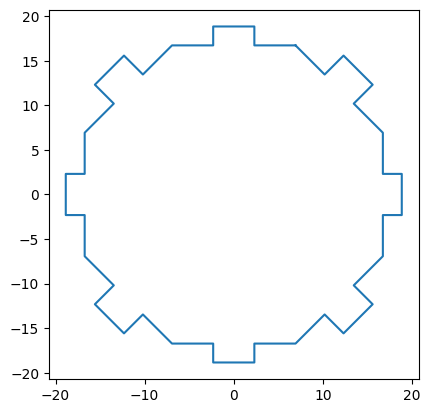

Octagon plotted!


In [43]:
plot_octagon()